In [140]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Data Cleaning, Feature Creation, Test-Train Split

Data came from https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting/

The task is to predict the power generated by a wind turbine from a set of relevant variables such as wind speed and direction and different parameters of the turbine such as the blade pitch angle.

In [141]:
dat=pd.read_csv('/home/maria/Documents/DataScienceProjects/data/Turbine_Data.csv',parse_dates=['Unnamed: 0'], index_col=['Unnamed: 0'])

In [142]:
#Drop rows with missing information
dat=dat.dropna()

In [143]:
#Check if there are columns that stay constant throughout the dataset
dat.nunique()

ActivePower                     32281
AmbientTemperatue               32723
BearingShaftTemperature         32712
Blade1PitchAngle                30077
Blade2PitchAngle                30116
Blade3PitchAngle                30116
ControlBoxTemperature               1
GearboxBearingTemperature       32712
GearboxOilTemperature           32724
GeneratorRPM                    31967
GeneratorWinding1Temperature    32724
GeneratorWinding2Temperature    32721
HubTemperature                  20358
MainBoxTemperature              26980
NacellePosition                  3950
ReactivePower                   32282
RotorRPM                        30844
TurbineStatus                     271
WTG                                 1
WindDirection                    3950
WindSpeed                       32722
dtype: int64

In [144]:
dat.drop(['WTG', 'ControlBoxTemperature'], axis=1, inplace=True)

In [145]:
dat.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
2019-05-06 14:10:00+00:00,-7.851491,39.308243,47.154927,45.736893,43.699357,43.699357,58.852308,56.782879,68.210284,62.792258,62.145290,46.003815,49.171875,44.80,-15.007223,0.672715,2.0,44.80,2.212693
2019-05-06 14:30:00+00:00,-5.565284,39.206277,40.058399,41.260297,41.260230,41.260230,48.911180,56.033333,68.229411,61.747975,61.282616,40.253338,44.515622,49.00,-10.851533,0.508198,2.0,49.00,2.130019
2019-05-06 14:50:00+00:00,-5.549332,39.194184,46.500652,39.576077,39.576122,39.576122,56.859428,55.873937,85.012009,60.785716,60.362536,46.003815,51.624993,61.50,-10.303578,0.715614,2.0,61.50,2.347810
2019-05-06 15:00:00+00:00,-5.768376,38.992667,46.419196,47.399521,48.299502,48.299502,56.761226,55.807661,63.945036,60.277575,59.855694,46.004238,51.900000,93.25,-12.594477,0.550434,129.0,93.25,2.161460
2019-05-06 15:10:00+00:00,-5.091456,38.686212,46.280597,50.363603,50.363691,50.363691,56.483241,55.451512,21.339981,60.004809,59.567618,46.007880,52.112507,138.50,-11.181515,0.251628,282.0,138.50,1.913490


In [172]:
#We need to remove data points where active power is negative, because these are erroneous measurements (generated power can't be negative).
dat=dat[dat['ActivePower']>0]
dat.shape

(26957, 19)

In [147]:
#Test-train split
#Let's put the first half of the data into one split and predict the second half of the data

y= dat['ActivePower']
predictors = dat.drop(['ActivePower'], axis=1)

#Do analysis on bigger chunk of data
#y_train=np.array(y.iloc[:16000]).reshape(-1,1)
#predictors_train=predictors.iloc[:16000]

#y_test=np.array(y.iloc[16000:]).reshape(-1,1)
#predictors_test=predictors.iloc[16000:]


y_train=np.array(y.iloc[:26000]).reshape(-1,1)
predictors_train=predictors.iloc[:26000]
predictors_train_ws=np.array(predictors['WindSpeed'][:26000]).reshape(-1,1)

y_test=np.array(y.iloc[26000:]).reshape(-1,1)
predictors_test=predictors.iloc[26000:]
predictors_test_ws=np.array(predictors['WindSpeed'][26000:]).reshape(-1,1)


In [161]:
#Baseline model predicting only based on wind speed

regression=Ridge(alpha=10)

regression.fit(predictors_train_ws,y_train)

preds=regression.predict(predictors_test_ws)
print(r2_score(y_test,preds))

0.8702740141855285


## Modeling

We employ PCA to find a small number of dimensions within the input columns to predict the power generated by the wind turbine.

Before applying we standardize the features onto a common scale by subtracting the mean and diving by standard devation. The resulting data has 0 mean and marks by how many standard deviations the data deviated from the mean. We also clip the outliers to 3 standard deviations.

In [149]:
scaler = StandardScaler()
standardized_train_features = scaler.fit_transform(predictors_train)
standardized_test_features = scaler.transform(predictors_test)
#Set outliers above 3 standard deviations to 3 std value
standardized_train_features = np.clip(standardized_train_features, -3, 3)
standardized_test_features = np.clip(standardized_test_features, -3, 3)

In [150]:
pca=PCA(n_components=18)
train_features=pca.fit_transform(standardized_train_features)

exp_var=pca.explained_variance_ratio_

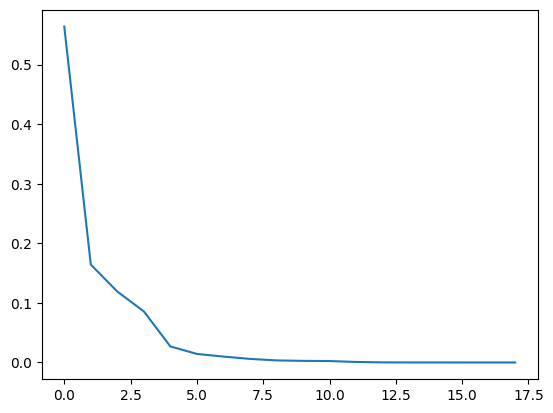

In [151]:
#Most of the variance seems to be captured by 
plt.plot(exp_var)

In [152]:
test_features=pca.transform(standardized_test_features)[:,:4]

In [153]:
test_features.shape

(957, 4)

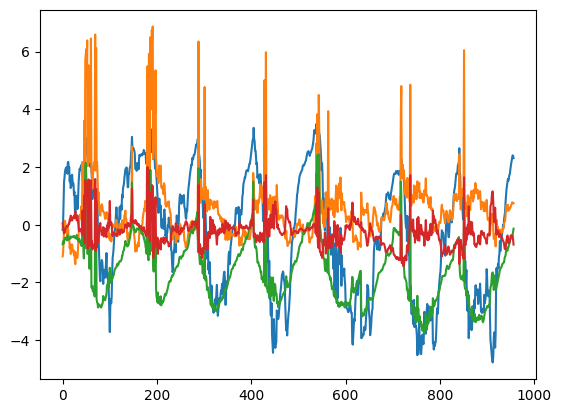

In [154]:
plt.plot(test_features)

In [155]:
regression=Ridge(alpha=10)

regression.fit(train_features[:,:4],y_train)

Ridge(alpha=10)

In [156]:
preds=regression.predict(test_features)
#Clip at zero
preds[preds<0]=0

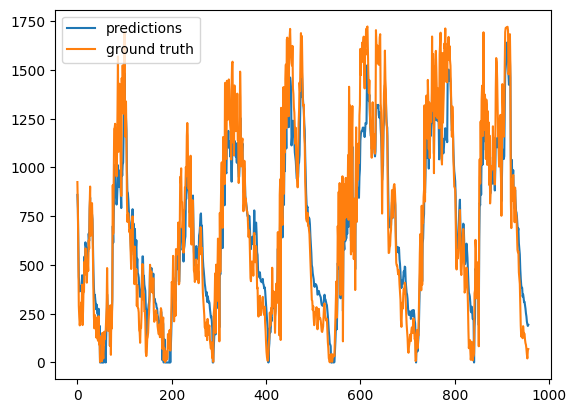

In [157]:
plt.plot(preds, label='predictions')
plt.plot(y_test, label='ground truth')
plt.legend()

In [158]:
np.corrcoef(preds.T,y_test.T)

array([[1.        , 0.96366993],
       [0.96366993, 1.        ]])

In [159]:
r2_score(y_test, preds)

0.897780074857662

In [160]:
#Regression with stronger regularization that sets unimportant variables to 0
l1_regr=Lasso()
l1_regr.fit(standardized_train_features,y_train)
preds=l1_regr.predict(standardized_test_features)
print(np.corrcoef(preds.T,y_test.T))
print(r2_score(y_test, preds))

[[1.         0.93166725]
 [0.93166725 1.        ]]
0.8530409820514286


/home/maria/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e+06, tolerance: 8.900e+05
  model = cd_fast.enet_coordinate_descent(


## Testing on a bigger dataset

Here we split the data into two halves, learn from the first half and predict the second half, in order to check whether the coefficients over PC's found by regression generalize to long time ranges. 

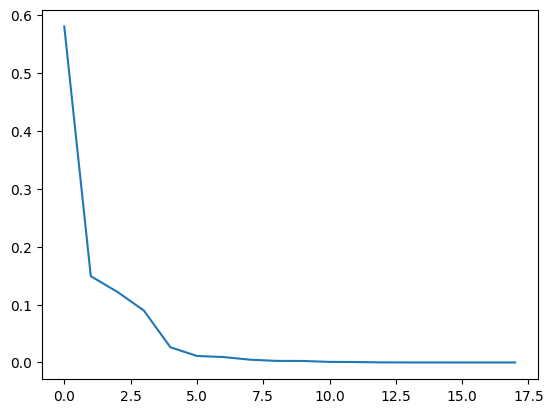

In [163]:
#Do analysis on bigger chunk of data
y_train=np.array(y.iloc[:16000]).reshape(-1,1)
predictors_train=predictors.iloc[:16000]

y_test=np.array(y.iloc[16000:]).reshape(-1,1)
predictors_test=predictors.iloc[16000:]

scaler = StandardScaler()
standardized_train_features = scaler.fit_transform(predictors_train)
standardized_test_features = scaler.transform(predictors_test)
#Set outliers above 3 standard deviations to 3 std value
standardized_train_features = np.clip(standardized_train_features, -3, 3)
standardized_test_features = np.clip(standardized_test_features, -3, 3)

pca=PCA(n_components=18)
train_features=pca.fit_transform(standardized_train_features)
test_features=pca.transform(standardized_test_features)[:,:4]

exp_var=pca.explained_variance_ratio_

plt.plot(exp_var)

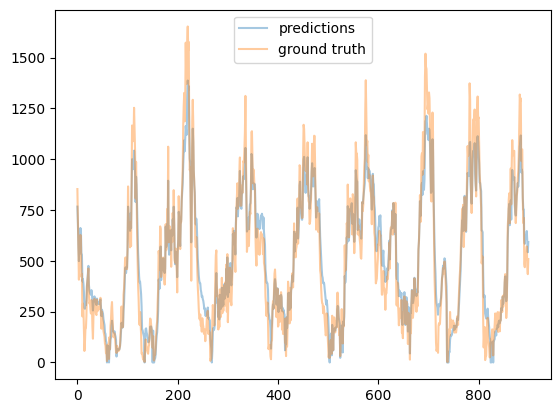

In [176]:
regression=Ridge(alpha=10)

regression.fit(train_features[:,:4],y_train)

preds=regression.predict(test_features)
#Clip at zero
preds[preds<0]=0

plt.plot(preds[:900], label='predictions', alpha=0.4)
plt.plot(y_test[:900], label='ground truth', alpha=0.4)
plt.legend()

In [171]:
print(np.corrcoef(preds.T,y_test.T))
r2_score(y_test, preds)

[[1.         0.97220245]
 [0.97220245 1.        ]]


0.9236905424222824

In [174]:
predictors_train_ws=np.array(predictors['WindSpeed'][:16000]).reshape(-1,1)
predictors_test_ws=np.array(predictors['WindSpeed'][16000:]).reshape(-1,1)

regression=Ridge(alpha=10)

regression.fit(predictors_train_ws,y_train)

preds=regression.predict(predictors_test_ws)
print(np.corrcoef(preds.T,y_test.T))
print(r2_score(y_test,preds))

[[1.         0.96688845]
 [0.96688845 1.        ]]
0.8687705348913621


The found relationship between PC's of predictors and the target (produced power) is robust. The variance explained and correlation coefficients are even higher than in predicting a small segment. This means that the operation of a turbine is predictable from a small number of principal components of relevant variables. 

Taking into account of the PC's of all of the variables gives a 6% improvement in variance eplained of the models relative to a baseline where we predict the generated power only based on the wind speed.